In [91]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
from ml_time_series import generate_envelope
import timeit
from datetime import datetime

In [321]:
import smtplib
from email.MIMEMultipart import MIMEMultipart
from email.MIMEText import MIMEText
from email.mime.image import MIMEImage

def send_email(text, img=False ,toaddr='jorgeluizjk@gmail.com'):
    fromaddr = 'ohperaml@gmail.com'
    passw = 'ohperaml11'
    msg = MIMEMultipart()
    msg['From'] = fromaddr
    msg['To'] = toaddr
    msg['Subject'] = "Jupyter - Processing completed"

    body = 'Processing completed\n' + text
    msg.attach(MIMEText(body, 'plain'))
    
    if img!=False:
        img_data = open(img, 'rb').read()
        image = MIMEImage(img_data, name=os.path.basename(img))
        msg.attach(image)

    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(fromaddr, passw)
    text = msg.as_string()
    server.sendmail(fromaddr, toaddr, text)
    server.quit()

In [188]:
files = ['data_154743','data_155334','data_155743','data_161034', 'data_161420', 'rob_data_170159']

DATAFILE = np.load('DB_HAND/'+files[1]+'.npy')
df = pd.DataFrame(DATAFILE, columns=['Sample','Label'])

df.head()

,Sample,Label
0,518.0,0.0
1,525.0,0.0
2,537.0,0.0
3,541.0,0.0
4,541.0,0.0


In [189]:
DATAFILE.shape

(30000, 2)

<IPython.core.display.Javascript object>


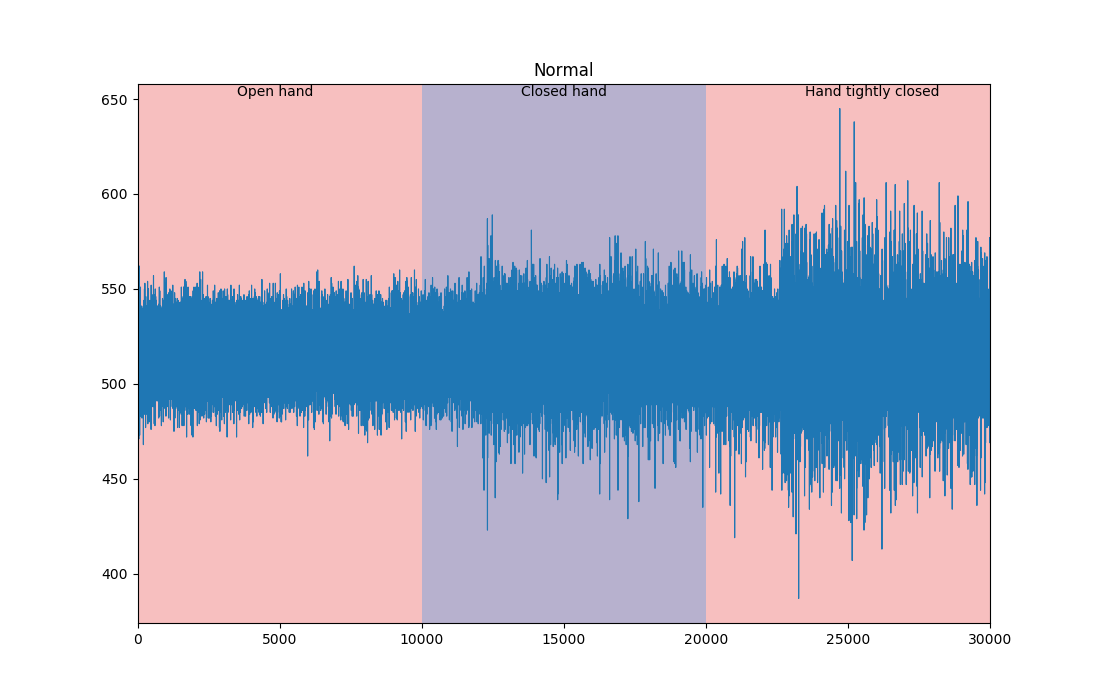

In [190]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure()

df['Sample'].plot(linewidth=0.8)
plt.title('Normal')

plt.axvspan(.0, 9999, facecolor='#F08080', alpha=0.5)
plt.axvspan(10000, 19999, facecolor='#70659e', alpha=0.5)
plt.axvspan(20000, 29999, facecolor='#F08080', alpha=0.5)
plt.annotate('Open hand', xy=(3500, df['Sample'].max()*1.01))  
plt.annotate('Closed hand', xy=(13500, df['Sample'].max()*1.01))
plt.annotate('Hand tightly closed', xy=(23500, df['Sample'].max()*1.01))

#fig_name = 'fig_' + files[0] + '.png'
fig.set_size_inches(w=11,h=7)
#fig.savefig(fig_name)

---
# Filtering
---

### RMS Function

In [191]:
import numpy as np
def window_rms(a, window_size):
    a2 = np.power(a,2)
    window = np.ones(window_size)/float(window_size)
    return np.sqrt(np.convolve(a2, window, 'valid'))

<IPython.core.display.Javascript object>


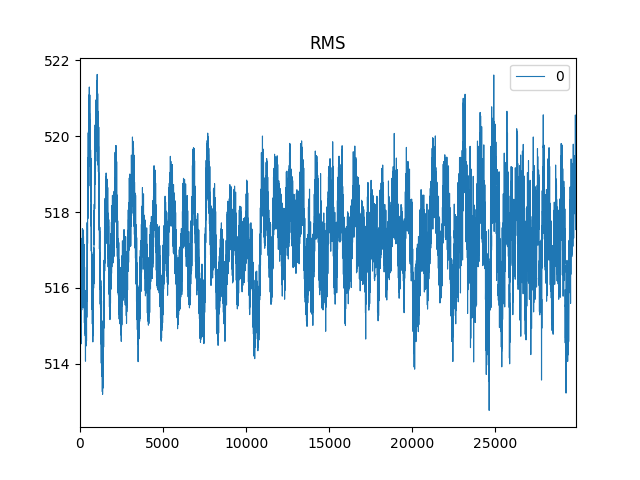

In [192]:
rms = window_rms(df['Sample'],150)

df_rms = pd.DataFrame(rms)

df_rms.plot(linewidth=0.8)
plt.title('RMS')

### Filter Function

In [63]:
def filteremg(time, emg, low_pass=10., sfreq=2000., high_band=20., low_band=450.):
    """
    time: Time data
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = abs(emg_filtered)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass/sfreq
    b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
    emg_envelope = sp.signal.filtfilt(b2, a2, emg_rectified)
    
    return emg_envelope

def plot_fremg(df):   
    # plot graphs
    fig = plt.figure()
    

    #plt.subplot(4, 1, 1).xaxis.set_visible(False)
    #plt.plot.set_title('Filtered, rectified ' + '\n' + 'EMG envelope: ' + str(int(40)) + ' Hz' + '\n VL-d')
    plt.plot(fr_emg['Time'], fr_emg['Filtered'])
    plt.locator_params(axis='x', nbins=4)
    plt.locator_params(axis='y', nbins=4)
    plt.axvspan(.0, 9999, facecolor='#F08080', alpha=0.5)
    plt.axvspan(10000, 19999, facecolor='#70659e', alpha=0.5)
    plt.axvspan(20000, 29999, facecolor='#F08080', alpha=0.5)
    plt.annotate('Open hand', xy=(3500, fr_emg['Filtered'].max()))  
    plt.annotate('Closed hand', xy=(13500, fr_emg['Filtered'].max()))
    plt.annotate('Hand tightly closed', xy=(23500, fr_emg['Filtered'].max()))
        

    #fig_name = 'fig_' + files[0] + '_filtered.png'
    #fig.set_size_inches(w=11,h=7)
    #fig.savefig(fig_name)



<IPython.core.display.Javascript object>


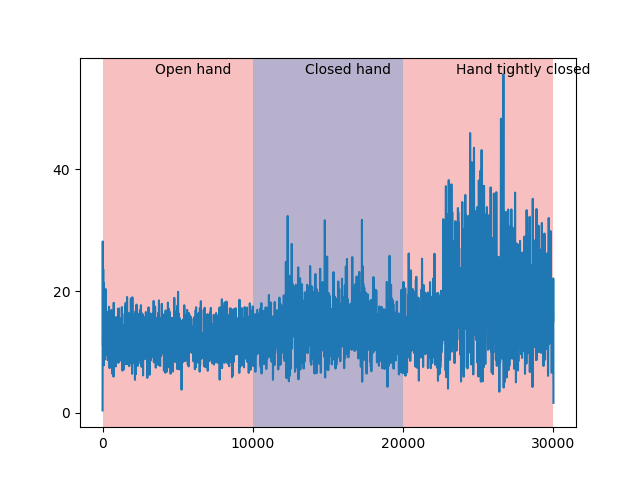

In [193]:
df['Time'] = (range(0,len(df)))
# show what different low pass filter cut-offs do
fr_emg = pd.DataFrame(df['Time'])

emg_correctmean = np.array(df['Sample'])
fr_emg['Filtered'] = pd.DataFrame(filteremg(df['Time'], emg_correctmean, low_pass=180))


plot_fremg(fr_emg)

### Process automation

In [8]:
def filter_signal(emg, low_pass=10., sfreq=2000., high_band=20., low_band=450.):
    """
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = abs(emg_filtered)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass/sfreq
    b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
    emg_envelope = sp.signal.filtfilt(b2, a2, emg_rectified)
    
    return emg_envelope

In [9]:
def plot_fremg(data):   
    # plot graphs
    fig = plt.figure()
    

    #plt.subplot(4, 1, 1).xaxis.set_visible(False)
    #plt.plot.set_title('Filtered, rectified ' + '\n' + 'EMG envelope: ' + str(int(40)) + ' Hz' + '\n VL-d')
    plt.plot(data)
    plt.locator_params(axis='x', nbins=4)
    plt.locator_params(axis='y', nbins=4)
    plt.axvspan(.0, 9999, facecolor='#F08080', alpha=0.5)
    plt.axvspan(10000, 19999, facecolor='#70659e', alpha=0.5)
    plt.axvspan(20000, 29999, facecolor='#F08080', alpha=0.5)
    plt.annotate('Open hand', xy=(3500, data.max()))  
    plt.annotate('Closed hand', xy=(13500, data.max()))
    plt.annotate('Hand tightly closed', xy=(23500, data.max()))
        

    fig_name = 'fig_' + str(int(40)) + '.png'
    fig.set_size_inches(w=11,h=7)
    fig.savefig(fig_name)

In [197]:
#plt.figure()
#plt.plot(filter_signal(df['Sample'], low_pass=3)[50:])

In [13]:
data = np.load('DB_HAND/'+'data_154743'+'.npy')

In [14]:
data = filter_signal(data[:,0], low_pass=3)

In [22]:
#plt.plot(data)

---
# Processing
---

In [211]:
def proccess_data(file_,DATA):

    #Load data and filter
    data = np.load('DB_HAND/'+file_+'.npy')
    #data = window_rms(data[:,0], 150)
    data = filter_signal(data[:,0], low_pass=180)
    #plot_fremg(data)
    Xc_1 = data[:10000]
    Xc_2 = data[10000:20000]
    Xc_3 = data[20000:]
    
    print '\nXc_1 filtered shape ', Xc_1.shape
    print 'Xc_2 filtered shape ', Xc_2.shape
    print 'Xc_3 filtered shape ', Xc_3.shape
    
    #Create temporal serie
    NUM_SAMPLES = 500
    
    Xc_1 = generate_envelope(Xc_1, NUM_SAMPLES)
    Xc_2 = generate_envelope(Xc_2, NUM_SAMPLES)
    Xc_3 = generate_envelope(Xc_3, NUM_SAMPLES)
    
    print 'Xc_1 temporal-serie shape ', Xc_1.shape
    print 'Xc_2 temporal-serie shape ', Xc_2.shape
    print 'Xc_3 temporal-serie shape ', Xc_3.shape
    
    #Labeling the type of movement
    C = (np.ones(len(Xc_1))*0).reshape((len(Xc_1),1))
    Xc_1 = np.hstack((Xc_1.reshape(Xc_1.shape),C.reshape((len(Xc_1),1))))


    C = (np.ones(len(Xc_2))*1).reshape((len(Xc_2),1))
    Xc_2 = np.hstack((Xc_2.reshape(Xc_2.shape),C.reshape((len(Xc_2),1))))
    
    C = (np.ones(len(Xc_3))*2).reshape((len(Xc_3),1))
    Xc_3 = np.hstack((Xc_3.reshape(Xc_3.shape),C.reshape((len(Xc_3),1))))
    
    print 'Xc_1 labeled shape ', Xc_1.shape
    print 'Xc_2 labeled shape ', Xc_2.shape
    print 'Xc_3 labeled shape ', Xc_3.shape
    
    # Salving in file on the folder <classifier_data>
    np.save('./preproc_filtered_data/'+file_+'_f_honp', Xc_1, allow_pickle=False)
    print file_+'_f_honp'+'.npy'    
    
    np.save('./preproc_filtered_data/'+file_+'_f_hclp', Xc_2, allow_pickle=False)
    print file_+'_f_hclp'+'.npy'

    np.save('./preproc_filtered_data/'+file_+'_f_hchp', Xc_3, allow_pickle=False)
    print file_+'_f_hchp'+'.npy'
    
    
    DATA.append(file_+'_f_honp.'+'npy')
    DATA.append(file_+'_f_hclp.'+'npy')
    DATA.append(file_+'_f_hchp.'+'npy')

In [212]:
files = ['data_154743','data_155334','data_155743','data_161034', 'data_161420']
DATA = []

start = timeit.default_timer()

for i in files:
    proccess_data(i,DATA)

stop = timeit.default_timer()

ti = stop - start 
print ('Tempo total para o envelopamento: %.2f min' % (ti/60))


Xc_1 filtered shape  (10000,)
Xc_2 filtered shape  (10000,)
Xc_3 filtered shape  (10000,)
Xc_1 temporal-serie shape  (9501, 500)
Xc_2 temporal-serie shape  (9501, 500)
Xc_3 temporal-serie shape  (9501, 500)
Xc_1 labeled shape  (9501, 501)
Xc_2 labeled shape  (9501, 501)
Xc_3 labeled shape  (9501, 501)
data_154743_f_honp.npy
data_154743_f_hclp.npy
data_154743_f_hchp.npy

Xc_1 filtered shape  (10000,)
Xc_2 filtered shape  (10000,)
Xc_3 filtered shape  (10000,)
Xc_1 temporal-serie shape  (9501, 500)
Xc_2 temporal-serie shape  (9501, 500)
Xc_3 temporal-serie shape  (9501, 500)
Xc_1 labeled shape  (9501, 501)
Xc_2 labeled shape  (9501, 501)
Xc_3 labeled shape  (9501, 501)
data_155334_f_honp.npy
data_155334_f_hclp.npy
data_155334_f_hchp.npy

Xc_1 filtered shape  (10000,)
Xc_2 filtered shape  (10000,)
Xc_3 filtered shape  (10000,)
Xc_1 temporal-serie shape  (9501, 500)
Xc_2 temporal-serie shape  (9501, 500)
Xc_3 temporal-serie shape  (9501, 500)
Xc_1 labeled shape  (9501, 501)
Xc_2 labeled s

In [213]:
%%bash
paplay /usr/share/sounds/freedesktop/stereo/complete.oga

In [214]:
Xc = np.load("preproc_filtered_data/"+DATA[0])
for i in DATA[1:]:
    Xc = np.vstack((Xc,np.load("preproc_filtered_data/"+i))) 

In [215]:
np.save('./preproc_filtered_data/row_data', Xc, allow_pickle=False)
print 'Xc saved as row_data.npy'

Xc saved as row_data.npy


---

In [272]:
Xc = np.load("preproc_filtered_data/row_data.npy")

In [273]:
Xc.shape

(142515, 501)

In [274]:
X = Xc[:,0:(Xc.shape[1]-2)]

yz = Xc[:,[(Xc.shape[1]-1)]]
y = np.array([])
for i in range(len(yz)):
    y = np.hstack((y,yz[i]))

X.shape, y.shape

((142515, 499), (142515,))

In [279]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [282]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
#X_valid_std = sc.transform(X_valid)

AttributeError: 'float' object has no attribute 'transform'

In [221]:
print X_train.shape, y_train.shape, X_test.shape

(106886, 499) (106886,) (35629, 499)


# Random Forest Classifier

In [257]:
#Training
print 'Training process:'
slt = ('Started at %s' % datetime.now().strftime('%H:%M:%S'))
print slt
sc = timeit.default_timer()

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, n_jobs = 4)
rfc = rfc.fit(X_train_std, y_train)

fc = timeit.default_timer()
flt = ('Finished at %s' % datetime.now().strftime('%H:%M:%S'))
print flt
tc = ('Total time %.4s min' % ((fc - sc)/60))
print tc
send_email(('\n Training process: \n %s \n %s \n %s \n' % (slt, flt, tc)))

Started at 08:18:09
Finished at 08:20:49
Total time 2.663 min


In [268]:
#Test
print 'Predicting process:'
slt = ('Started at %s' % datetime.now().strftime('%H:%M:%S'))
print slt
sc = timeit.default_timer()

y_pred = rfc.predict(X_test_std)
from sklearn.metrics import accuracy_score
acc = ('ClassifyRF accuracy:---------->%.2f %%' % (accuracy_score(y_test, y_pred)*100))

fc = timeit.default_timer()
flt = ('Finished at %s' % datetime.now().strftime('%H:%M:%S'))
print flt
tc = ('Total time %.4s min' % ((fc - sc)/60))
print tc
print acc
send_email(('\n Predict process: \n %s \n %s \n %s \n %s' % (slt, flt, tc, acc)))

Predict time
Started at 08:36:05
Finished at 08:36:06
Total time 0.01 min
ClassifyRF accuracy:---------->99.17 %


### Validation

In [225]:
DATAV = []
proccess_data('rob_data_170159',DATAV)

Xc = np.load("preproc_filtered_data/"+DATAV[0])
for i in DATAV[1:]:
    Xc = np.vstack((Xc,np.load("preproc_filtered_data/"+i)))
    
Xvalid = Xc[:,0:(Xc.shape[1]-2)]

yz = Xc[:,[(Xc.shape[1]-1)]]
yvalid = np.array([])
for i in range(len(yz)):
    yvalid = np.hstack((yvalid,yz[i]))

print Xvalid.shape, yvalid.shape


Xc_1 filtered shape  (10000,)
Xc_2 filtered shape  (10000,)
Xc_3 filtered shape  (10000,)
Xc_1 temporal-serie shape  (9501, 500)
Xc_2 temporal-serie shape  (9501, 500)
Xc_3 temporal-serie shape  (9501, 500)
Xc_1 labeled shape  (9501, 501)
Xc_2 labeled shape  (9501, 501)
Xc_3 labeled shape  (9501, 501)
rob_data_170159_f_honp.npy
rob_data_170159_f_hclp.npy
rob_data_170159_f_hchp.npy
(28503, 499) (28503,)


In [284]:
#Validation
print 'Validation process:'
slt = ('Started at %s' % datetime.now().strftime('%H:%M:%S'))
print slt
sc = timeit.default_timer()

std.fit(X_train)
X_valid_std = std.transform(Xvalid)
y_pred = rfc.predict(X_valid_std)
from sklearn.metrics import accuracy_score
acc = ('ClassifyRF accuracy:---------->%.2f %%' % (accuracy_score(y_pred, yvalid)*100))

fc = timeit.default_timer()
flt = ('Finished at %s' % datetime.now().strftime('%H:%M:%S'))
print flt
tc = ('Total time %.4s min' % ((fc - sc)/60))
print tc
print acc
send_email(('\n Validation process: \n %s \n %s \n %s \n %s' % (slt, flt, tc, acc)))

Validation process:
Started at 08:44:22
Finished at 08:44:23
Total time 0.01 min
ClassifyRF accuracy:---------->84.01 %


## Confusion Matrix

<IPython.core.display.Javascript object>


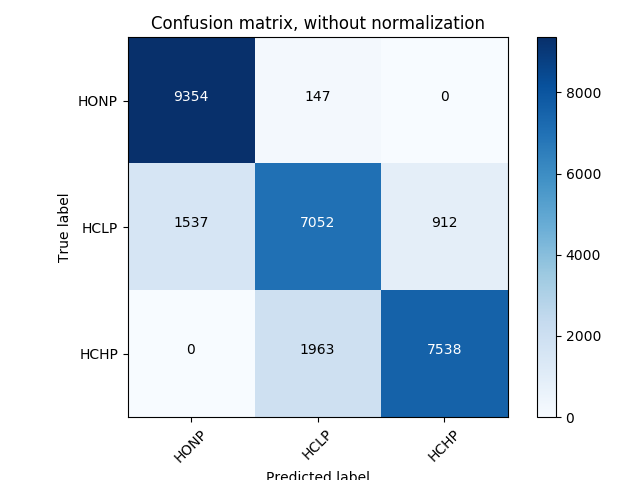

Confusion matrix, without normalization
[[9354  147    0]
 [1537 7052  912]
 [   0 1963 7538]]


<IPython.core.display.Javascript object>


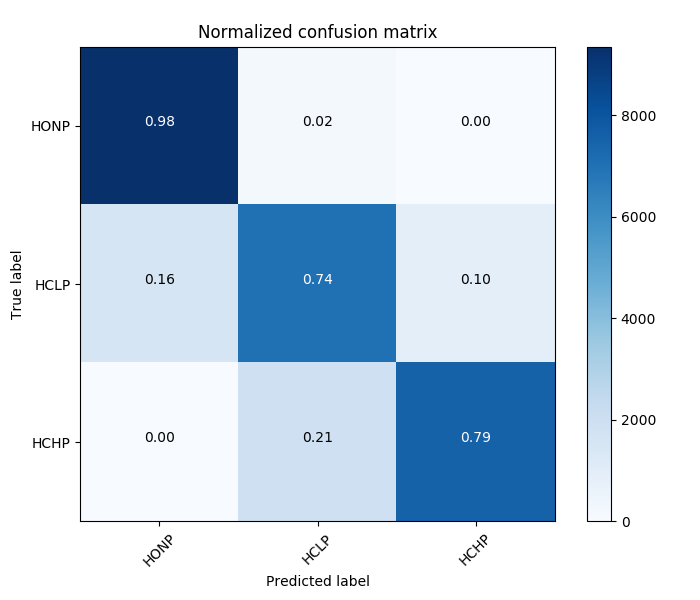

Normalized confusion matrix
[[ 0.98  0.02  0.  ]
 [ 0.16  0.74  0.1 ]
 [ 0.    0.21  0.79]]


In [311]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

%matplotlib notebook
class_names = np.array(['HONP', 'HCLP', 'HCHP'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, ('%.2f' % cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    else:
        print('Confusion matrix, without normalization')
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    print(cm)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(yvalid, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig_name = 'cm.png'
fig.set_size_inches(w=7,h=6)
fig.savefig(fig_name)

plt.show()

In [329]:
cm = confusion_matrix(yvalid, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
TPa = float(cm[0][0])
Eab = float(cm[0][1])
Eac = float(cm[0][2])
#####################
Eba = float(cm[1][0])
TPb = float(cm[1][1])
Ebc = float(cm[1][2])
#####################
Eca = float(cm[2][0])
Ecb = float(cm[2][1])
TPc = float(cm[2][2])

Pa = TPa/(TPa+Eba+Eca)
Pb = TPb/(TPb+Eab+Ecb)
Pc = TPc/(TPc+Eac+Ebc)

Ra = TPa/(TPa+Eab+Eab)
Rb = TPb/(TPb+Eba+Ebc)
Rc = TPc/(TPc+Eca+Ecb)

TNa = TPb+Ebc+Ecb+TPc
TNb = TPa+Eac+Eca+TPc
TNc = TPa+Eab+Eba+TPb

Sa = TNa/(TNa+Eba+Eca)
Sb = TNb/(TNb+Eab+Eac)
Sc = TNc/(TNc+Eac+Ebc)

Acc = (TPa+TPb+TPc)/(TPa+Eab+Eac+Eba+TPb+Ebc+Eca+Ecb+TPc)

print 'PERFORMANCE MEASURES BY CONFUSION MATRIX'
acc = ('Accuracy: %.2f %%' % (Acc*100))
print acc 
print ''
sa = ('Sensitivity-A: %.2f %%' % (Ra*100))
print sa 
sb = ('Sensitivity-B: %.2f %%' % (Rb*100))
print sb
sc = ('Sensitivity-C: %.2f %%' % (Rc*100))
print sc
print ''
pa = ('Precision-A: %.2f %%' % (Pa*100))
print pa
pb = ('Precision-B: %.2f %%' % (Pb*100))
print pb
pc = ('Precision-C: %.2f %%' % (Pc*100))
print pc
print ''
spa = ('Specificity-A: %.2f %%' % (Sa*100))
print spa
spb = ('Specificity-B: %.2f %%' % (Sb*100))
print spb
spc = ('Specificity-C: %.2f %%' % (Sc*100))
print spc

PERFORMANCE MEASURES BY CONFUSION MATRIX
Accuracy: 84.01 %

Sensitivity-A: 96.95 %
Sensitivity-B: 74.22 %
Sensitivity-C: 79.34 %

Precision-A: 85.89 %
Precision-B: 76.97 %
Precision-C: 89.21 %

Specificity-A: 91.91 %
Specificity-B: 99.14 %
Specificity-C: 95.20 %


In [333]:
send_email(('\n Validation process: \n %s \n %s \n %s \n\n PERFORMANCE MEASURES BY CONFUSION MATRIX \n %s \n\n %s \n %s \n %s \n\n %s \n %s \n %s \n\n %s \n %s \n %s \n\n' % (slt, flt, tc, acc, sa, sb, sc, pa, pb, pc, spa, spb, spc)), 'cm.png', 'ithallojunior@outlook.com')


# Support Vector Machine

In [15]:
#Training

from sklearn import svm, datasets

print 'Processing time SVM'
%time svm = svm.SVC(kernel='rbf', gamma=0.2, C=6, decision_function_shape='ovr').fit(X_train_std, y_train)

print ''

from sklearn.metrics import accuracy_score

Processing time SVM
CPU times: user 2h 32min 31s, sys: 4.66 s, total: 2h 32min 36s
Wall time: 2h 32min 49s



In [17]:
#Test

print 'Predict time'  
%time y_pred = svm.predict(X_test_std)
from sklearn.metrics import accuracy_score
print ('SVM-RBF accuracy:---------->%.2f %%' % (accuracy_score(y_test, y_pred)*100))

Predict time
CPU times: user 25min 9s, sys: 1.12 s, total: 25min 10s
Wall time: 25min 12s
SVM-RBF accuracy:---------->83.53 %


In [19]:
#Validation

print 'Predict time'  
%time y_pred = svm.predict(X_valid_std)
from sklearn.metrics import accuracy_score
print ('SVM-RBF accuracy:---------->%.2f %%' % (accuracy_score(y_test[:len(X_valid_std)], y_pred)*100))

Predict time
CPU times: user 20min 14s, sys: 56 ms, total: 20min 14s
Wall time: 20min 15s
SVM-RBF accuracy:---------->33.21 %


# GridSearch

In [ ]:
from sklearn.grid_search import GridSearchCV
param_grid = [
    {
        'C'     : [0.001, 0.01, 0.1, 1, 10, 50, 100, 1000], 
        'gamma' : [1000, 100, 80, 50, 35, 10, 1, 0.1, 0.01, 0.001, 0.0001], 
        'kernel': ['rbf'],
        'random_state' : [1,5,10,100,500,1000,10000]
    },
]    
clf = GridSearchCV(svm.SVC(decision_function_shape='ovr'), param_grid, cv=15)
%time clf.fit(X_train_std, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))
print()

# Gaussian Naive Bayes Classifier

In [10]:
from sklearn.naive_bayes import GaussianNB

gnbc = GaussianNB()
print 'Training time'
%time gnbc.fit(X_train_std, y_train)

pred = gnbc.predict(X_test)

from sklearn.metrics import accuracy_score
print ('ClassifyNB accuracy:---------->%.2f %%' % (accuracy_score(y_test, pred)*100))

ClassifyNB accuracy:---------->33.45 %


# Ada Boost Classifier

In [11]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=100, learning_rate = 2.5395)
print 'Training time'
%time abc = abc.fit(X_train_std, y_train)
print''

print 'Predict time'
%time pred = abc.predict(X_test_std)

print''

from sklearn.metrics import accuracy_score


print ('ClassifyAB accuracy:---------->%.2f %%' % (accuracy_score(y_test, pred)*100))


Predict time
CPU times: user 1.39 s, sys: 8 ms, total: 1.4 s
Wall time: 1.4 s

ClassifyAB accuracy:---------->46.83 %


In [385]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

print 'Training time'
# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=2, max_features='sqrt', max_depth=2), algorithm="SAMME", n_estimators=1200)

%time bdt.fit(X_train_std, y_train)

print 'Predict time'
%time pred = bdt.predict(X_test_std)

print''
print ('ClassifyAB accuracy:---------->%.2f %%' % (accuracy_score(y_test, pred)*100))

std.fit(X_train)
X_valid_std = std.transform(Xvalid)
y_pred = bdt.predict(X_valid_std)
from sklearn.metrics import accuracy_score
acc = ('ClassifyRF accuracy:---------->%.2f %%' % (accuracy_score(y_pred, yvalid)*100))
print acc

Training time
CPU times: user 18min 30s, sys: 1.15 s, total: 18min 31s
Wall time: 18min 33s
Predict time
CPU times: user 13.1 s, sys: 16 ms, total: 13.1 s
Wall time: 13.1 s

ClassifyAB accuracy:---------->62.42 %
ClassifyRF accuracy:---------->71.92 %


In [386]:
%%bash
paplay /usr/share/sounds/freedesktop/stereo/complete.oga

# KNeighbors Classifier

In [227]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=8, weights='distance', algorithm='auto', p=10, n_jobs=4)
print 'Training time'
%time knc = knc.fit(X_train_std, y_train)
print''

print 'Predict time'
%time pred = knc.predict(X_test_std)

print''

from sklearn.metrics import accuracy_score



print ('ClassifyKN accuracy:---------->%.2f %%' % (accuracy_score(y_test, pred)*100))

Training time
CPU times: user 4.5 s, sys: 0 ns, total: 4.5 s
Wall time: 4.54 s

Predict time
CPU times: user 9h 25min 35s, sys: 24 s, total: 9h 25min 59s
Wall time: 2h 31min 19s

ClassifyKN accuracy:---------->99.89 %


In [228]:
print 'Predict time'
%time pred = knc.predict(X_valid_std)

print''

from sklearn.metrics import accuracy_score



print ('ClassifyKN accuracy:---------->%.2f %%' % (accuracy_score(y_test[:len(X_valid_std)], pred)*100))

Predict time
CPU times: user 5h 30min 53s, sys: 8.94 s, total: 5h 31min 2s
Wall time: 1h 57min

ClassifyKN accuracy:---------->33.21 %


# Decision Tree

In [359]:
print 'Training process:'
slt = ('Started at %s' % datetime.now().strftime('%H:%M:%S'))
print slt
sc = timeit.default_timer()

from sklearn import tree
dtc = tree.DecisionTreeClassifier(min_samples_split=2, max_features='sqrt')
dtc = dtc.fit(X_train_std, y_train)

fc = timeit.default_timer()
flt = ('Finished at %s' % datetime.now().strftime('%H:%M:%S'))
print flt
tc = ('Total time %.4s min' % ((fc - sc)/60))
print tc

Training process:
Started at 10:41:47
Finished at 10:41:53
Total time 0.09 min


In [360]:
print 'Predicting process:'
slt = ('Started at %s' % datetime.now().strftime('%H:%M:%S'))
print slt
sc = timeit.default_timer()

y_pred = dtc.predict(X_test_std)
from sklearn.metrics import accuracy_score
print ('ClassifyDT accuracy:---------->%.2f %%' % (accuracy_score(y_test, y_pred)*100))

fc = timeit.default_timer()
flt = ('Finished at %s' % datetime.now().strftime('%H:%M:%S'))
print flt
tc = ('Total time %.4s min' % ((fc - sc)/60))
print tc

Predicting process:
Started at 10:41:53
ClassifyDT accuracy:---------->88.05 %
Finished at 10:41:53
Total time 0.00 min


In [361]:
#Validation
print 'Validation process:'
slt = ('Started at %s' % datetime.now().strftime('%H:%M:%S'))
print slt
sc = timeit.default_timer()

std.fit(X_train)
X_valid_std = std.transform(Xvalid)
y_pred = dtc.predict(X_valid_std)
from sklearn.metrics import accuracy_score
acc = ('ClassifyRF accuracy:---------->%.2f %%' % (accuracy_score(y_pred, yvalid)*100))

fc = timeit.default_timer()
flt = ('Finished at %s' % datetime.now().strftime('%H:%M:%S'))
print flt
tc = ('Total time %.4s min' % ((fc - sc)/60))
print tc
print acc

Validation process:
Started at 10:41:53
Finished at 10:41:53
Total time 0.01 min
ClassifyRF accuracy:---------->67.55 %


In [362]:
%%bash
paplay /usr/share/sounds/freedesktop/stereo/complete.oga

In [368]:
dtc.max_depth_

AttributeError: 'DecisionTreeClassifier' object has no attribute 'max_depth_'